## SUMMARY OF POSSIBILITIES TO DO CAUSAL ANALYSIS

### Creation of random data to show applications in code

In [1]:
from ensurepip import bootstrap

import pandas as pd
import numpy as np

np.random.seed(123)
#creation of treatment
T_binary = np.random.randint(0,2, 100)
T_continuous = np.random.randint(200, 601, 100)
#creation of X variables
x1, x2, x3 = np.random.randint(0,2, 100), np.random.randint(16, 31, 100), np.random.randint(18, 66, 100)
#creation of Y variable
y_binary = np.random.randint(0,2, 100)
y_continuous = np.random.randint(4000, 8001, 100)

In [2]:
df_yB_TB = pd.DataFrame(zip(y_binary,T_binary,x1,x2,x3), columns=['Pass_test', 'Invitation_training', 'Gender', 'Education', 'Age'])
df_yB_TC = pd.DataFrame(zip(y_binary,T_continuous,x1,x2,x3), columns=['Pass_test', 'Subvention', 'Gender', 'Education', 'Age'])
df_yC_TC = pd.DataFrame(zip(y_continuous,T_continuous,x1,x2,x3), columns=['Wage', 'Subvention', 'Gender', 'Education', 'Age'])
df_yC_TB = pd.DataFrame(zip(y_continuous,T_binary,x1,x2,x3), columns=['Wage', 'Invitation_training', 'Gender', 'Education', 'Age'])

Different df combining continuous and binary outcome / treatment


In [3]:
df_yB_TB.sample(5)

,Pass_test,Invitation_training,Gender,Education,Age
74,0,1,0,21,37
66,1,0,0,23,49
10,1,1,1,23,55
36,1,1,0,20,63
37,0,0,0,21,50


### 1. Linear regression

#### 1.1. Assumptions and general informations about linear regression

1) Linear regression (Lr) is a minimization problem: try to min. the MSE
2) Lr is like A/B testing and gives already statistics such as p-values, confidence-interval (CI), ...
3) Lr model: y = b0 + b1x, where b0 is intercept (expected y when all x set to 0), and b1 is effect on y for a changes in x, and effect of x on y is b0+b1
4) The FRISH-WAUGH-LOWEL theorem: debiasing and denoising steps: when multiple X regressors: Y and T are regressed on X so that the last step is the regression of Y on T residuals. This means no correlations between X and T: remove the confounding
5) Lr can handle non-linearities by changing the regressor into non-linearity: add dummy variables, interaction terms, polynomials
6) Open question still this day: bias-variance tradeoff in Lr: might include X variables to control for confounding to reduce bias but might increase the variance if the X variable predict strongly (T or Y) and weakly (Y or T). Might be possible to drop an X that doesn't predict strongly both to increase bias but reduce variance BUT ONLY IF X predicts strongly T and weakly Y !
7) Assumptions general in causal: Randomization is the best way to do causal. SUTVA: stable unit treatment values assumption: effect to a person is only due to its assignment to the treatment, not by others assignment: no spillover effect. Independence assumption: potential outcomes are independent of the treatment. It ensures that both groups are comparable (same background characteristics) and only differ by the treatment assignment.


#### 1.2. Application using statsmodels

In [4]:
import statsmodels.formula.api as smf

OLS = smf.ols('Wage~C(Invitation_training)', data=df_yC_TB).fit() #in statsmodels: C() for categorical variables

In [5]:
OLS.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6174.9636,175.037,35.278,0.000,5827.609,6522.319
C(Invitation_training)[T.1],-114.6747,260.930,-0.439,0.661,-632.481,403.132


We see here that to be invited to the training reduces the wage by 114.67 units (CHF). The result is not significant (p-value>0.05). The average wage of people who don't receive the training is 6174 CHF.

In [6]:
OLS = smf.ols('Wage~C(Invitation_training)+C(Gender)+Education+Age', data=df_yC_TB).fit()

In [7]:
OLS.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5261.0846,845.567,6.222,0.000,3582.421,6939.748
C(Invitation_training)[T.1],-99.3457,265.966,-0.374,0.710,-627.355,428.664
C(Gender)[T.1],190.8575,268.658,0.710,0.479,-342.495,724.210
Education,10.8380,28.925,0.375,0.709,-46.584,68.260
Age,13.1362,9.646,1.362,0.176,-6.013,32.285


Here, we controlled for confounding and we see now to be invited reduced less the wage: -99.24 compared at -114 before but this result is still not significant.

### 2. Propensity score models

#### 2.1. General informations about propensity score

1) Propensity score (Ps) is the probability to be treated given X: P(T|X). It is then possible to control for the Ps which is one-dimensional instead of the X variables which are high-dimensional. Controlling for Ps makes the assignment to the treatment again as good as randomly assigned !
2) A binary treatment: can approximate the Ps function with a logit model
3) We will see in the following chapter: Ps with Lr / Ps matching estimators / Inverse Probability weighting estimator (IPW) / Doubly robust estimator (DR)
4) We will aslo see models for continuous treatment but more complicated
5) When Treatment is binary: better use IPW or DR. When Treatment is continuous: better use Lr

#### 2.2. Ps with Lr models

In [8]:
ps_score = smf.logit('Invitation_training~C(Gender)+Education+Age', data=df_yC_TB).fit(disp=0) #estimate P(T|X). disp=0 not to have message

In [9]:
data_ps = df_yC_TB.assign(Propensity_score=ps_score.predict(df_yC_TB)) #assign new col with ps

In [10]:
OLS = smf.ols('Wage~C(Invitation_training)+Propensity_score', data=data_ps).fit() #estimate effect

In [11]:
OLS.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6394.8515,695.287,9.197,0.000,5014.900,7774.803
C(Invitation_training)[T.1],-99.8510,266.021,-0.375,0.708,-627.828,428.126
Propensity_score,-503.4635,1540.203,-0.327,0.744,-3560.339,2553.412


I have almost same result as before: training reduces wage by 99.85 CHF and is not significant

In [12]:
OLS.params['C(Invitation_training)[T.1]']

-99.8510103027154

#### 2.3. Propensity score matching

1) Ps matching is an estimator that matches a treated with a non-treated observation based on their Ps (also possible with X variables). E.g.: T=1 having Ps=0.7 is match with T=0 having Ps=0.7: u compute then their difference in Y; This process is done for all observations and the Average treatment effect (ATT) is the average of all the invididual differences.
2) Possible to do matching based on k closest neighbors and use average outcome of the k observations as counterfactual.
3) This estimator is sensible on the quality of the match: if matches aren't good, might get a biased estimator

In [13]:
from sklearn.neighbors import KNeighborsRegressor

y, T, X = 'Wage', 'Invitation_training', 'Propensity_score'

treated = data_ps.query(f"{T}==1")
non_treated = data_ps.query(f"{T}==0")

mt0 = KNeighborsRegressor(n_neighbors=1).fit(non_treated[[X]], non_treated[y]) #Need [[X]] to get a 2D and not a pandas series 1D using [X], which is allowed for outcome y --> [y]
mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[[X]], treated[y])

predicted = pd.concat([treated.assign(match=mt0.predict(treated[[X]])), non_treated.assign(match=mt1.predict(non_treated[[X]]))]) #using assign creates a copy of treated, non_treated but created new df predicted

ATE = np.mean((predicted[y]-predicted['match'])*predicted[T]+(predicted['match']-predicted[y])*(1-predicted[T]))

1) Creation of 2 samples with only treated or non-treated observations
2) Creation of 2 models to predict y, based on treated or non_treated data: KNneigbors uses the k (here 1) nearest neighbors in terms of X (here Ps) and use the average of y of the k observations as the prediction y.
3) Concatenation of the 2 samples into 1, also adding a new column match which is the prediction of the outcome if observation was opposite treatment group. Concatenation based on axis=0, rows one under the other, so we have first the treated sample observations and under it the non_treated obseravations
4) Use the formula of the matching estimator to get the ATE


In [14]:
print(f"ATE of matching estimator based on Ps: {ATE}")

ATE of matching estimator based on Ps: -300.89


In [15]:
isinstance(treated[[X]], pd.DataFrame), isinstance(treated[X], pd.Series)

(True, True)

To check if DataFrame or pd.Series

#### 2.4. Inverse Probability Weighting (IPW): 1/Ps

1) IPW reweight the observations based on their Ps: this creates a new subpopulation that adjust for confounding and selection bias
2) Observations with high / low Ps gets less / more importance if they have characteristics X representative of the other group. E.g: T0 with Ps = 0.7 --> non_treated with characteristics of treated group, give more importance to this observation
3) X is balanced across groups after reweighting: Treatment again as if randomly assigned because treated and non-treated are comparable in terms of X (Ps). Indeed, the weighting transform the distribution of Ps in a kind of uniform distribution for both groups so that they overlapp. Before: distribution of treated was growing in Ps and inverse for the non-treated.
4) To sum up: Inverse Probability Weighting (IPW) adjusts the influence of each observation to create a balanced pseudo-population. Underrepresented individuals receive higher weights, amplifying their impact, while overrepresented ones get lower weights, reducing their influence. This reweighting process ensures that the distribution of covariates (or propensity scores) becomes more similar across treatment groups. As a result, IPW mimics randomization, making groups more comparable and reducing selection bias.
5) Withdraws of IPW: might get problem when Ps close to 0 and 1 because of the weight they receive. Don't get directly statics and need to compute manually.

Formula of the ATE: E[(1(T=1)Y / P(T=1|X)] - E[1(T=0)Y / P(T=0|X)]

Here we calculate first the weight, so instead of divide by Ps, we multiply by the weight

In [16]:
weight_treated = 1 / data_ps.query(f'{T}==1')['Propensity_score'] #weight = 1/Ps
weight_non_treated = 1 / (1-(data_ps.query(f'{T}==0')['Propensity_score']))

In [17]:
t1 = data_ps.query(f'{T}==1')[y] #to get column of outcome for T=1
t0 = data_ps.query(f'{T}==0')[y]

In [18]:
y1 = sum(t1 * weight_treated) / len(data_ps) # apply separatly the formula of ATE: Expectation of y1
y0 = sum(t0 * weight_non_treated) / len(data_ps) # expectation of y0

In [19]:
ATE = y1 - y0
print(f"IPW result is: ATE = {ATE:.2f}")

IPW result is: ATE = -142.49


Possible to use a simplified formula of ATE: E[Y* ((T-P_score/P_score*(1-P_score))]

In [20]:
ATE = np.mean(data_ps[y] * (data_ps[T] - data_ps['Propensity_score']) / (data_ps['Propensity_score']*(1-data_ps['Propensity_score'])))
print(f'{ATE:.2f}')

-142.49


Now creating a bootstrapp to calculate statistics

In [21]:
from joblib import Parallel, delayed #used to do different task in heart of processor at same time --> earn time

def Bootstrap(data, function, rounds=999, seed=123, CI=[2.5, 97.5]):
    np.random.seed(seed)
    statistics = Parallel(n_jobs=4)( #here statistics creates a list of averages calculated in each sample
        delayed(function)(data.sample(frac=1, replace=True)) #data.sample recreate a new data of same size with replacement
        for _ in range(rounds)
    )
    return np.percentile(statistics, CI) #np.percentile(takes list of number, a percentile to calculate)

My Bootsrapp function need to get a function inside to calcul its statistics, i need then to create a function of my ATE.
1) Careful, need to assign first y, T to column of data

In [22]:
def IPW_ATE(data: pd.DataFrame) -> float: #indications to remember type of variables to include

    ATE = np.mean(data[y] * (data[T] - data['Propensity_score']) / (data['Propensity_score']*(1-data['Propensity_score'])))
    return ATE

In [23]:
result = Bootstrap(data_ps, IPW_ATE)
effect = IPW_ATE(data_ps)
print(f"ATE of {effect:.2f} with a 95% CI: {result}")

ATE of -142.49 with a 95% CI: [-2716.19909046  2175.26898059]


Confidence interval containing the 0, the result of the difference is not significant!

In [24]:
lower, upper = result #to have better representation
print(f"ATE: {effect:.2f}; 95% CI: [{lower:.2f}, {upper:.2f}]")

ATE: -142.49; 95% CI: [-2716.20, 2175.27]


#### 2.5. Doubly Robust (DR) estimator

1) Combine outcome estimation and propensity score estimation: usually Lr and logistic model (but can also be other models)
2) Yt: ûtDR(m,e) = E[m(X)] + E[(T/e(x))*(Y-m(X)] ; where e(x) = P-Score
3) Allow to have an unbiased estimator if at least one of the two models is correctly specified --> get true ATE
4) If outcome estimation correct --> right part of equation = 0, and we directly get the correct outcome estimation
5) If p_score correct, the left part (rearranged) = 0 and we get the IPW model on the right which estimates correctly outcome because the p_score is also correct

ATE : u1DR(m,e) - u0DR(m,e) ; where e = estimated p_score and m estimated outcome model

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix

def doubly_robust(data, formula, T, y):
    X = dmatrix(formula, data)
    ps_model = LogisticRegression(penalty=None, max_iter=1000).fit(X, data[T])
    ps = ps_model.predict_proba(X)[:,1] #return 2 columns: P(T=0|X) and P(T=1|X) --> [:,1] to get only Ps to be treated
    mu0 = LinearRegression().fit(X[data[T] == 0, :], data.query(f'{T}==0')[y])
    mu1 = LinearRegression().fit(X[data[T] == 1, :], data.query(f'{T}==1')[y])
    mu0_hat = mu0.predict(X)
    mu1_hat = mu1.predict(X)
    return (
        np.mean(data[T]*(data[y] - mu1_hat)/ps + mu1_hat) - np.mean((1-data[T])*(data[y] - mu0_hat)/(1-ps)+mu0_hat)
    )

1) Explanation of the code:
2) dmatrix transforms data into statistics form (e.g.: C(Gender) is directly transformed into dummy. Possible to add into return_type='dataframe' to get variables in df type.
3) Use predict_proba for logistic model to get probabilities because predict returns 0 or 1 as outcome. CAREFUL, with statsmodels, predict gives the probabilities !!!
4) X[data[T] == 0, :] is the same as data.query but because of the form of dmatrix, cannot use it there.
5) DR returns ATE with its formula

In [26]:
data = df_yC_TB
formula = 'C(Gender) + Education + Age'
T = 'Invitation_training'
y = 'Wage'
result = doubly_robust(data, formula, T, y)
print(f"ATE of DR estimator: {result:.2f}")

ATE of DR estimator: -109.22


Try to reproduce DR estimator using statsmodels

In [27]:
def Doubly_robust_Statsmodels(data, X, T, y):
    ps_score = smf.logit(f'{T}~{X}', data = data).fit(disp=0)
    ps = ps_score.predict(data)
    treated = data.query(f'{T}==1')
    non_treated = data.query(f'{T}==0')
    mu0 = smf.ols(f'{y}~{X}', data=treated).fit()
    mu1 = smf.ols(f'{y}~{X}', data=non_treated).fit()
    mu0_hat = mu0.predict(data)
    mu1_hat = mu1.predict(data)
    return (
        np.mean(data[T]*(data[y] - mu1_hat)/ps + mu1_hat) - np.mean((1-data[T])*(data[y] - mu0_hat)/(1-ps)+mu0_hat)
    )

In [28]:
data = df_yC_TB
X = 'C(Gender) + Education + Age'
T = 'Invitation_training'
y = 'Wage'

In [29]:
result = Doubly_robust_Statsmodels(data, X, T, y)
print(f'ATE of DR using statsmodels: {result:.2f}')

ATE of DR using statsmodels: -106.47


Time to run some statistics

In [30]:
from toolz import partial

stats = partial(doubly_robust, formula=formula, T=T, y=y)
print(f"95% CI : {Bootstrap(df_yC_TB, stats)}")


95% CI : [-641.86603929  417.05463053]


In [31]:
stats = partial(Doubly_robust_Statsmodels, X=X, T=T, y=y)
print(f"95% CI : {Bootstrap(df_yC_TB, stats)}")

95% CI : [-622.20144663  417.72740923]


1) Partial allow to keep some argument of a function fixed: partial(function, arguments to keep fix)
2) So allow doing Bootstrapp without having to specify each time what are the variables of the function in DR

Estimating propensity score for Continuous treatement variables

#### 2.6. Generalized propensity score for continuous treatment

1) More complicated with continous treatment: first problem is that P(T=t)=0 because the probability of a continuous variable is 0 everywhere because the proba is represented by the area under the density, and the area under a single point = 0.
2) Solution is to work with conditional density function f(T|X) instead of conditional probability P(T=t|X)
3) But next problem is that we need to assume a distribution of the treatment. E.g. normal distribution

In [32]:
df_yC_TC.columns

Index(['Wage', 'Subvention', 'Gender', 'Education', 'Age'], dtype='object')

In [33]:
df_yC_TC.dtypes

Wage          int32
Subvention    int32
Gender        int32
Education     int32
Age           int32
dtype: object

In [34]:
df_yC_TC[['Subvention', 'Wage']] = df_yC_TC[['Subvention', 'Wage']].astype('float')

In [35]:
df_yC_TC[['Subvention', 'Wage']].dtypes

Subvention    float64
Wage          float64
dtype: object

In [36]:
from causal_curve import GPS_Regressor
gps = GPS_Regressor()
gps.fit(T = df_yC_TC['Subvention'], X = df_yC_TC[['Gender', 'Education', 'Age']], y = df_yC_TC['Wage'])
gps_result = gps.calculate_CDRC(0.95)

C:\Users\Jonathan\PycharmProjects\pythonProject\projetAnaylse\venv\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The inverse_power link alias is deprecated. Use InversePower instead. The inverse_power link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [37]:
gps_result.columns

Index(['Treatment', 'Causal_Dose_Response', 'Lower_CI', 'Upper_CI'], dtype='object')

This method is good to produce a graph then to represent the causality

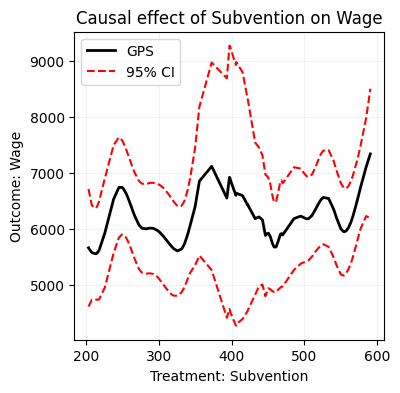

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.plot(gps_result['Treatment'], gps_result['Causal_Dose_Response'], color='black', linewidth=2, label='GPS')
plt.plot(gps_result['Treatment'], gps_result['Lower_CI'], color='red', linestyle='--', label='95% CI')
plt.plot(gps_result['Treatment'], gps_result['Upper_CI'], color='red', linestyle='--')
plt.xlabel('Treatment: Subvention')
plt.ylabel('Outcome: Wage')
plt.title('Causal effect of Subvention on Wage')
plt.grid(color='gray', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

Now to get the ATE for this method with Continous treatment and Continuous outcome

In [39]:
model_t = smf.ols('Subvention~C(Gender) + Education + Age', data=df_yC_TC).fit() #use then fittes values as mean and sd of residual as sd

from scipy.stats import norm
gps = norm(loc=model_t.fittedvalues, scale=np.std(model_t.resid)).pdf(df_yC_TC['Subvention'])
final_model = smf.wls('Wage~Subvention', data=df_yC_TC, weights= 1/gps).fit()
result = final_model.params['Subvention']
print(f'ATE: {result:.2f}')

ATE: 1.65


We needed to assume a distribution for the treatment, decided normal distribution:
1) Estimate treatment with linear reg
2) create the generalized propensity score (gps) with normal distribution using prediction of Subvention as mean and sd of residuals of Lr as sd and all this estimated at given treatment
3) Just regress Y on T, using weighted least square and using weights
4) Problem of method: give lots of weights to observations far of the regression --> create high variance: Need to stabilize the weights with marginal density

In [40]:
stabilizer = norm(
    loc = df_yC_TC['Subvention'].mean(),
    scale = np.std(df_yC_TC['Subvention'] - df_yC_TC['Subvention'].mean()) #usually dont need write diff: but already np.sdt(df_cont_t['interest'])
    ).pdf(df_yC_TC['Subvention'])
gipw = stabilizer/gps #new weights stabilized
final_model = smf.wls('Wage~Subvention', data=df_yC_TC, weights=gipw).fit()
result = final_model.params['Subvention']
print(f'ATE stabilized: {result:.2f}')

ATE stabilized: 1.11


To get the statistics, again, need to create a function of the ATE with gps, and then pass it into the bootstrapp function

In [41]:
from scipy.stats import norm
def ATE_gps(data, X, T, y):
    model_t = smf.ols(f'{T}~{X}', data=data).fit()
    gps = norm(loc=model_t.fittedvalues, scale=np.std(model_t.resid)).pdf(data[f'{T}'])
    final_model = smf.wls(f'{y}~{T}', data=data, weights= 1/gps).fit()
    result = final_model.params[f'{T}']
    return result

In [42]:
data = df_yC_TC
X = 'C(Gender) + Education + Age'
T = 'Subvention'
y = 'Wage'
ATE_gps(data, X, T, y)

1.650949947891732

In [43]:
from scipy.stats import norm
def ATE_stab(data, X, T, y):
    model_t = smf.ols(f'{T}~{X}', data=data).fit()
    gps = norm(loc=model_t.fittedvalues, scale=np.std(model_t.resid)).pdf(data[f'{T}'])
    stabilizer = norm(
    loc = data[f'{T}'].mean(),
    scale = np.std(data[f'{T}'] - data[f'{T}'].mean()) #usually dont need write diff: but already np.sdt(df_cont_t['interest'])
    ).pdf(data[f'{T}'])
    gipw = stabilizer/gps #new weights stabilized
    final_model = smf.wls(f'{y}~{T}', data=data, weights=gipw).fit()
    result = final_model.params[f'{T}']
    return result

In [44]:
a =ATE_stab(data, X, T, y)
a

1.1062186138105754

Now that functions have been created, introduce into bootstrapp

In [45]:
from toolz import partial

stats = partial(ATE_stab, X=X, T=T, y=y)
CID, CIU = Bootstrap(df_yC_TC, stats) #data, statistic
print(f"ATE_stab: {a:.2f}, 95% CI : ({CID:.4f}, {CIU:.4f})")

ATE_stab: 1.11, 95% CI : (-1.2189, 2.9583)


### 4. Effect heterogeneity and personalization: Conditional average treatment effect (CATE)

Think that treatment affects differently depending on the background characteristics X. Want to know then the effect for the different groups and apply the treatment to the ones where effect on outcome is the higher.

1) Conditioning on X means to allow treatment effect to be different depending on the characteristics
2) Careful, prediction is not best to find personalization of the treatment, because we search for different slopes into data and not at outcome. We want to split data into different segment to see which groups react best with treatment. We want to predict the slope of outcome based on treatment for each unit, which is the problem again in causal analysis because cannot see each unit into different treatment levels / states.
3) CATE: want to predict: dY/dT

Import new data for CATE: question is to know when to give discounts to customers: where discounts where randomized

In [46]:
data = pd.read_csv("C:\\Users\\Jonathan\\PycharmProjects\\Raw data\\daily_restaurant_sales.csv")
data.head(2)

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales
0,0,2016-01-01,1,4,False,True,False,False,2.88,0,79.0
1,0,2016-01-02,1,5,True,False,False,False,2.64,0,57.0


Unit here day-restaurant combination

#### 4.1. CATE with Regression

1) When estimating ATE: with regression, we get the b1 coeff: which is the constant effect for everyone
2) Simply add some interaction terms between the Treatment and the Covariates X: if we differentiate again by t, we now obtain the following effect: b1 + b3*Xi. We can see then the changes in slope by a change in X.

In [47]:
import statsmodels.formula.api as smf

In [48]:
X = ['C(month)', 'C(weekday)', 'is_holiday', 'competitors_price']
reg_CATE = smf.ols(f'sales~discounts*{"+".join(X)}', data=data).fit()

Now that we have our CATE model, we need to estimate / predict the slope. To do so, need to use the definition of derivative, and by approximating it, we find that dy/dt = y(t+1) - y(t)

We need so to estimate y(t+1) and y(t): we have 2 predictions to do.

In [49]:
first_pred = reg_CATE.predict(data.assign(discounts=data['discounts']+1))
second_pred = reg_CATE.predict(data)
ols_cate_pred = first_pred - second_pred

ols_cate_pred has a vector of slope prediction for each individual = CATE prediction

We now have to find a way to evaluate this model, because we have the prediction of the CATE, but cannot compare predictions to actual values of data because actual treatment effect is not observed at a unit level!

1) Using ML to do predictions and evaluation: e.g. Cross-validation
2) Define a benchmark model: random model to see if CATE better than a naive model
3) To compare and evaluate models in terms of unobservable truth (true cate), need to measure treatment effect not by individuals but small groups

In [50]:
train = data.query('day<"2018-01-01"')
test = data.query('day>="2018-01-01"')

In [51]:
X = ['C(month)', 'C(weekday)', 'is_holiday', 'competitors_price']
reg_CATE = smf.ols(f'sales~discounts*({"+".join(X)})', data=train).fit() #only train data

In [52]:
first_pred = reg_CATE.predict(test.assign(discounts=test['discounts']+1))
second_pred = reg_CATE.predict(test)
cate_pred = first_pred - second_pred

Model creation and predictions on different datasets. Now create 2 new models to compare later

In [53]:
from sklearn.ensemble import GradientBoostingRegressor

X = ['month', 'weekday', 'is_holiday', 'competitors_price', 'discounts']
y = ['sales']
np.random.seed(1)
ml_model = GradientBoostingRegressor(n_estimators=50).fit(train[X], train[y])
ml_pred = ml_model.predict(test[X])

In [54]:
np.random.seed(123)
random_pred = np.random.uniform(-1, 1, len(test))

In [55]:
test_pred = test.assign(
    ml_pred=ml_pred,
    cate_pred=cate_pred,
    random_pred=random_pred
)

In [56]:
test_pred.head(5)

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales,ml_pred,cate_pred,random_pred
731,0,2018-01-01,1,0,False,True,False,False,4.92,5,251.5,236.312960,41.355802,0.392938
732,0,2018-01-02,1,1,False,False,False,False,3.06,10,541.0,470.218050,44.743887,-0.427721
733,0,2018-01-03,1,2,False,False,False,False,4.61,10,431.0,429.180652,39.783798,-0.546297
734,0,2018-01-04,1,3,False,False,False,False,4.84,20,760.0,769.159322,40.770278,0.102630
735,0,2018-01-05,1,4,False,False,False,False,6.29,0,78.0,83.426070,40.666949,0.438938


#### 4.1.1 Effect by Model Quantile

1) The CATE prediction allow then to order the observations / units per sensitivity to the treatment: ordering units less sensitive to most sensitive to the treatment.
2) You can evaluate groups defined by the ordering. Segment data by quantiles of the cate prediction and estimate the effect by quantile. If the estimated effect in each quantile is ordered, the cate model is also good at ordering the true CATE.

In [57]:
from toolz import curry

@curry
def effect(data, y, t):
    return (np.sum((data[t] - data[t].mean())* data[y]) /
            np.sum((data[t] - data[t].mean())**2))

@curry allows to partially apply function, and to have only argument being data frame. This function applied to whole test set gives the ATE.

In [58]:
def effect_by_quantile(df, pred, y, t, q=10):
    groups = np.round(pd.IntervalIndex(pd.qcut(df[pred], q=q)).mid, 2) #quantile partitions
    return (df.assign(**{f"{pred}_quantile": groups}).groupby(f"{pred}_quantile", group_keys=False).apply(effect(y=y, t=t)))

In [75]:
z = effect_by_quantile(test_pred, 'cate_pred', y='sales', t='discounts')
z

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_18920\2057200387.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return (df.assign(**{f"{pred}_quantile": groups}).groupby(f"{pred}_quantile", group_keys=False).apply(effect(y=y, t=t)))


cate_pred_quantile
17.50    20.494153
23.93    24.782101
26.85    27.494156
28.95    28.833993
30.81    29.604257
32.68    32.216500
34.65    35.889459
36.75    36.846889
39.40    39.125449
47.36    44.272549
dtype: float64

In [73]:
test_pred['discounts'].max()

40

In [60]:
z.index

Index([17.5, 23.93, 26.85, 28.95, 30.81, 32.68, 34.65, 36.75, 39.4, 47.36], dtype='float64', name='cate_pred_quantile')

1) Observations: quantile left and effect right: we see that effects increase by quantiles --> this show that the CATE prediction is indeed ordering the effect! Second, the midpoint prediction in each quantile (index column) is close to the effect for the same quantile --> CATE not only order the true CATE well, but also predict the True CATE correctly!

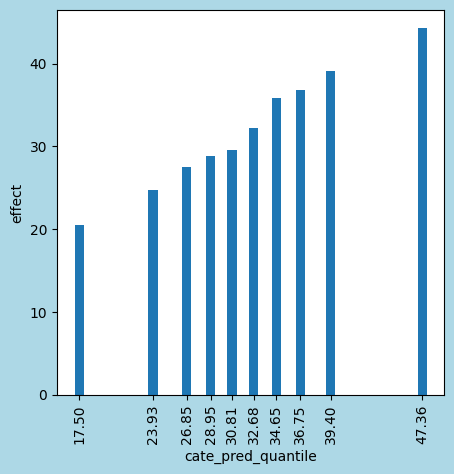

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5), facecolor='lightblue')
plt.bar(x=z.index, height=z['effect'])
plt.xlabel('cate_pred_quantile')
plt.ylabel('effect')
plt.xticks(z.index, rotation=90)
plt.show()

It is then possible to compare models with differents plots to see which one is the best (the steaper the stairshape). But can be possible also to compare with only one value, which is easier to understand

In [62]:
def cumulative_gain_curve(df, prediction, y, t, ascending=False, normalize=False, steps=100):
    effect_fn = effect(t=t, y=y)
    normalizer = effect_fn(df) if normalize else 0
    size = len(df)
    ordered_df = (df.sort_values(prediction, ascending=ascending).reset_index(drop=True))
    steps = np.linspace(size / steps, size, steps).round(0)
    effects = [(effect_fn(ordered_df.query(f"index<={row}")) - normalizer)*(row/size)for row in steps]
    return np.array([0] + effects)
gain = cumulative_gain_curve(test_pred, "cate_pred", "sales", "discounts")
gain

array([ 0.        ,  0.50387597,  0.982917  ,  1.38863289,  1.83046877,
        2.2690746 ,  2.71880783,  3.13779256,  3.57577084,  4.01798404,
        4.42379877,  4.83861979,  5.23242282,  5.62890903,  5.98551452,
        6.38159081,  6.74402024,  7.13257317,  7.5088165 ,  7.9068624 ,
        8.26968674,  8.63441305,  9.03646968,  9.41649072,  9.76869065,
       10.13172457, 10.48178647, 10.85654343, 11.20031099, 11.57715392,
       11.88179285, 12.22484979, 12.65329367, 13.00147394, 13.35835129,
       13.75177168, 14.08571614, 14.44720258, 14.8206963 , 15.16915263,
       15.48942971, 15.87058782, 16.18483861, 16.5889676 , 16.87711862,
       17.226077  , 17.51523959, 17.85547549, 18.1943502 , 18.48062947,
       18.77790182, 19.05825319, 19.38214231, 19.7240743 , 20.00659491,
       20.35269886, 20.65268403, 20.93862963, 21.18225404, 21.53351325,
       21.82793867, 22.09450014, 22.38142964, 22.62161465, 22.87752468,
       23.11063608, 23.3799479 , 23.70688475, 23.97456335, 24.32

In [63]:
print(f"AUC for cate_pred: {sum(gain)}")

AUC for cate_pred: 1805.9206376114457


Compare this area with other models and better is higher number! AUC for area under the curve.

#### 4.1.1.1. Target transformation (quantile)

Possible to create a target variable that approximates the true treatment effect of the quantile in expectations. This allows then to use MSE to evaluate model. Careful, due to the model approximation, target close to the treatment average will have a denominator close to 0, need then to use weights to recover the problem, such as (Ti-ut(Xi))^2

1) Create the target, which is the residual of outcome regression divided by residual of treatment regression

In [66]:
X = ["C(month)", "C(weekday)", "is_holiday", "competitors_price"]
resid_y = smf.ols(f"sales~{'+'.join(X)}", data=test).fit().resid
resid_t = smf.ols(f"discounts~{'+'.join(X)}", data=test).fit().resid
tau_hat = resid_y/resid_t #target

2. Compare each model in terms of MSE when targeting tau_hat

In [69]:
from sklearn.metrics import mean_squared_error

for i in ['ml_pred', 'random_pred', 'cate_pred']:
    mse = mean_squared_error(tau_hat, test_pred[i], sample_weight=resid_t**2) #mse(true_y, y_pred, weight)
    print(f"MSE of {i} model: {mse}")


MSE of ml_pred model: 576256.7425385385
MSE of random_pred model: 1115.803515760459
MSE of cate_pred model: 42.90447405550277


We can again see with the MSE that the best model is the CATE. It is also interesting to see that ml model is worst than the random because it aims at outcome, and not the quantile!

#### 4.2. Summary of effect heterogeneity

1) want to know the causal effect of each unit to better allocate the treatment. But in causal inference, cannot know each unit causal effect: it is unobservable.
2) If u assume that the causal effect depends on observable variables X, u can go from ATE to Conditional Average Treatment Effect (CATE). CATE allows knowing how causal effect changes depending on X variables.
3) Quantile creates k groups of same size with observations close in terms of X variables. Then, it is possible to estimate the ATE in each of the groups to see where the treatment has more effect on the outcome, this gives the CATE.
4) It is then possible to estimate groups effect: using linear regression by just adding interaction terms between treatment and covariates: CATE(X)=dY/dT=β1+β3X
5) Easiest way to compare then models to see which is best is by creating target and evaluating with MSE
6) RANDOMIZED DATA IS VERY IMPORTANT TO DO CATE ESTIMATION, NOT TO HAVE BIASED ESTIMATES!!!
7) Quantile vs percentile: represent k groups of same size based on chara X vs value for which k% of observations are equal or below